# VQE with GBS on Strawberryfields

This tutorial introduces how to implement a variational quantum eigensolver (VQE) with Gaussian Bosonic Sampling on Strawberryfields platform which simulates bosonic modular processes. Qiskit provides another way to implement VQE on quantum circuits.

VQE makes use of the variational method, based on the variational principle, to find approximations to the lowest energy eigenstate or ground state, and some excited states. This allows calculating approximate wavefunctions such as molecular orbitals.

In [ ]:
#@title Install & import the necessary packages
!pip install strawberryfields
!pip install tensorflow
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.2-py3-none-any.whl size=144547 sha256=d981c041274fdbdb6a1440afafa135a7d33d14d7350bbbe30586a1952322fa0f
  Stored in directory: /root/.cache/pip/wheels/af/c8/1f/dd6d90c5974896e85709e017986a6f72fcf32343bea042bc03
  Created wheel for thewalrus: filename=thewalrus-0.20.0-py3-none-any.whl size=91858 sha256=a6b6dba6abb2

In [ ]:
import numpy as np
import strawberryfields as sf
from strawberryfields.ops import * # Avoid *
from strawberryfields.utils import operation
import tensorflow as tf
from matplotlib import pyplot as plt

## Set up global parameters
These global parameters apply to the rest of the tutorial.

- cutoff: number of levels per bosonic mode, i.e., Fock dimension truncation.
- depth: number of repeating layers in the circuit
- reps: number of optimization steps
- lr: learning rate for tf optimizers, shows how much the optimized parameters move along the gradient direction
- std: standard deviations used for normal distribution.
- set_seed: ensure reproducibility over runs.

In [ ]:
cutoff = 6
depth = 4
reps = 50
lr = 0.1
std = 0.01
active_std = 0.001
passive_std = 0.1
# Global seed to ensure reproducibility over runs
tf.random.set_seed(42)

In [ ]:
# Define function to plot fidelity vs opt step
def plot_fid(fid_progress):

    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.sans-serif"] = ["Computer Modern Roman"]
    plt.style.use("default")

    plt.plot(fid_progress)
    plt.ylabel("Fidelity")
    plt.xlabel("Step")

# Define function to plot energy vs opt step
def plot_energy(E_progress):

    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.sans-serif"] = ["Computer Modern Roman"]
    plt.style.use("default")

    plt.plot(E_progress)
    plt.ylabel("Energy")
    plt.xlabel("Step")

## Strawberryfields platform

Instead of a discrete qubit model in quantum computing, Strawberryfields utilizes a continuous-variable (CV) model that allows simulation of bosonic systems (light is intrinsically continuous). The associated architecture with controllable gates realizes the Gaussian boson sampling (GBS) algorithm that can be applied to different fields such as graph problems, machine learning, chemistry...

In preparing the known architecture in Strawberryfields, the main steps are:
1. sf.Program(number of modes) is declared
2. An engine backend is specified. Here, we are using the TensorFlow backend for later optimization.
3. Define quantum circuit/program with operations in sf.ops.
4. Run engine, extract properties from results.state.

A sample program is given below:

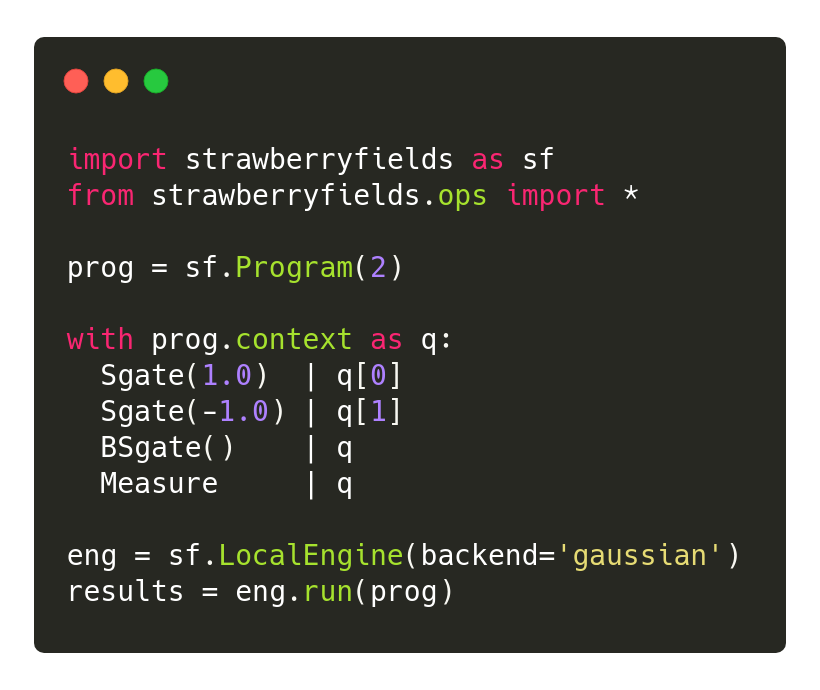

## Optimize to coherent state from vacuum via displacement gate

The coherent state $|\alpha\rangle$ is defined as the eigenstate corresponding to eigenvalue $\alpha$ of the annihilation operator (lowering the quantum state level by 1) $\hat{a}$: $$\hat{a}|\alpha\rangle=\alpha|\alpha\rangle$$

Given the target statevector $|\psi_t\rangle$ in Fock basis, the Uhlmann's fidelity (or overlap) between the pure output state $|\psi\rangle$ and pure target state is measured by $F=|\langle \psi|\psi_t\rangle|^2$. By Cauchy-Schwarz inequality, $F\leq 1$. Here, we run an optimization for *hyperparameter* $\Theta$ containing all parameters involved in each operation/gate in each layer of the circuit so as to maximize the fidelity $F$ near 1 as possible.

In [ ]:
# initialize engine and program objects
eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": 6})
circuit = sf.Program(1)

tf_r = tf.Variable(tf.random.normal(shape=[], stddev=0.001)) # center = .. to define center
tf_phi = tf.Variable(tf.random.normal(shape=[], stddev=0.001))

r, phi = circuit.params("r", "phi")

# define circuit
with circuit.context as q:
    Dgate(r, phi) | q[0]

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
steps = 100
best_fid = 0
# target coherent state in Fock basis
alpha = 0.70710678118+0.70710678118j
coh = lambda a, dim: np.array([np.exp(-0.5 * np.abs(a) ** 2) * (a) ** n / np.sqrt(np.math.factorial(n)) for n in range(dim)])
target_statevec = coh(alpha,cutoff)
# opt starts here
for step in range(steps):

    # reset the engine if it has already been executed
    if eng.run_progs:
        eng.reset()

    with tf.GradientTape() as tape:
        # execute the engine
        results = eng.run(circuit, args={"r": tf_r, "phi": tf_phi})
        # get the probability of fock state |1>
        fid = results.state.fidelity_coherent([alpha])
        # save ket vector
        ket = results.state.ket()
        # negative sign to maximize prob
        loss = 1-tf.sqrt(fid)

    gradients = tape.gradient(loss, [tf_r, tf_phi])
    opt.apply_gradients(zip(gradients, [tf_r, tf_phi]))
    print("Fidelity at step {}: {}".format(step, fid))
    if fid > best_fid:
        best_fid = fid
        best_r = tf_r
        best_phi = tf_phi
        learnt_state = ket.numpy()

    if step == 0:
        first_step_state = ket.numpy()

print(best_fid.numpy(),best_r.numpy(),best_phi.numpy())

Fidelity at step 0: 0.3680497705936432
Fidelity at step 1: 0.4252866804599762
Fidelity at step 2: 0.4904997646808624
Fidelity at step 3: 0.5645280480384827
Fidelity at step 4: 0.6463038921356201
Fidelity at step 5: 0.7328833937644958
Fidelity at step 6: 0.8188886642456055
Fidelity at step 7: 0.8962191939353943
Fidelity at step 8: 0.9547762870788574
Fidelity at step 9: 0.9855102300643921
Fidelity at step 10: 0.9869111776351929
Fidelity at step 11: 0.9699645638465881
Fidelity at step 12: 0.9499524235725403
Fidelity at step 13: 0.9353761672973633
Fidelity at step 14: 0.9280573725700378
Fidelity at step 15: 0.9265669584274292
Fidelity at step 16: 0.9283620119094849
Fidelity at step 17: 0.9311681985855103
Fidelity at step 18: 0.9340303540229797
Fidelity at step 19: 0.9376556277275085
Fidelity at step 20: 0.9435904622077942
Fidelity at step 21: 0.9527386426925659
Fidelity at step 22: 0.9644930958747864
Fidelity at step 23: 0.9769711494445801
Fidelity at step 24: 0.9878649115562439
Fidelity a

Given $\alpha=re^{i\phi} \in ℂ$, the corresponding coherent state $|\alpha\rangle$ can be obtained by the displacement gate $D(\alpha)|0\rangle = |\alpha\rangle$. In the previous example, we take $\alpha=\frac{1}{\sqrt{2}}+\frac{1}{\sqrt{2}}i = e^{i\frac{\pi}{4}}$. Indeed, $r$ is *optimized* to $\approx 1$, and $\phi$ is *optimized* to $\approx \frac{\pi}{4}$.

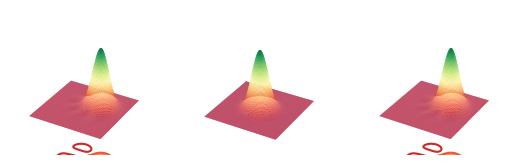

In [ ]:
#@title  Visualizing results
from matplotlib import animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def wigner(rho):
    """This code is a modified version of the 'iterative' method
    of the wigner function provided in QuTiP, which is released
    under the BSD license, with the following copyright notice:

    Copyright (C) 2011 and later, P.D. Nation, J.R. Johansson,
    A.J.G. Pitchford, C. Granade, and A.L. Grimsmo.

    All rights reserved."""
    import copy

    # Domain parameter for Wigner function plots
    l = 5.0
    cutoff = rho.shape[0]

    # Creates 2D grid for Wigner function plots
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)

    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m) * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

rho_target = np.outer(target_statevec, target_statevec.conj())
rho_first_learnt = np.outer(first_step_state, first_step_state.conj())
rho_learnt = np.outer(learnt_state, learnt_state.conj())

fig1 = plt.figure()
ax1 = fig1.add_subplot(131, projection="3d")
X, P, W = wigner(rho_target)
ax1.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax1.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax1.set_axis_off()
ax2 = fig1.add_subplot(132, projection="3d")
X, P, W = wigner(rho_first_learnt)
ax2.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax2.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax2.set_axis_off()
ax3 = fig1.add_subplot(133, projection="3d")
X, P, W = wigner(rho_learnt)
ax3.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax3.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax3.set_axis_off()
fig1.show()

## Hong-Ou-Mandel effect
[Description](https://en.wikipedia.org/wiki/Hong%E2%80%93Ou%E2%80%93Mandel_effect) With a 50-50 beamsplitter $(\theta\approx\frac{\pi}{4})$, when two identical photons each enter an input port, they will always exit together in the same output mode. In other words, a Fock state of $|11\rangle$ can be transformed to either $|02\rangle$ or $|20\rangle$, regardless of the value of $\phi$.

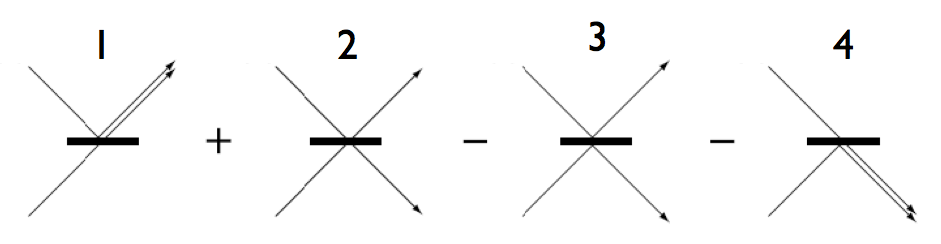

In [ ]:
# initialize engine and program objects
eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": 7,"prepare_fock_state":[1,0],"prepare_fock_state":[1,1]})
circuit = sf.Program(2)

tf_theta = tf.Variable(tf.random.normal(shape=[], stddev=0.001))
tf_phi = tf.Variable(tf.random.normal(shape=[], stddev=0.001))

theta, phi = circuit.params("theta", "phi")

with circuit.context as q:
    Fock(1) | q[0]
    Fock(1) | q[1]
    BSgate(theta, phi) | (q[0],q[1])

opt = tf.keras.optimizers.Adam(learning_rate=0.1)
steps = 50
best_prob = 0

for step in range(steps):

    # reset the engine if it has already been executed
    if eng.run_progs:
        eng.reset()

    with tf.GradientTape() as tape:
        # execute the engine
        results = eng.run(circuit, args={"theta": tf_theta, "phi": tf_phi})
        # get the probability of fock state |1>
        # print(results.state.is_pure)
        prob = results.state.fock_prob([0,2])+results.state.fock_prob([2,0]) # sum of (0,2) and (2,0) Fock prob
        # prob = tf.abs(results.state.fidelity_coherent([0,1]))
        # negative sign to maximize prob
        loss = 1-tf.sqrt(prob)

    gradients = tape.gradient(loss, [tf_theta, tf_phi])
    opt.apply_gradients(zip(gradients, [tf_theta, tf_phi]))
    print("Prob at step {}: {}".format(step, prob))
    if prob > best_prob:
        best_prob = prob
        best_theta = tf_theta
        best_phi = tf_phi
        best_state = results.state

print(best_prob.numpy(),best_theta.numpy(),best_phi.numpy())
# sf.plot.generate_fock_chart(best_state,[0,1],7)

Prob at step 0: 1.2503591051427065e-06
Prob at step 1: 0.0399077869951725
Prob at step 2: 0.15236955881118774
Prob at step 3: 0.3191103935241699
Prob at step 4: 0.512732207775116
Prob at step 5: 0.7016579508781433
Prob at step 6: 0.8566773533821106
Prob at step 7: 0.9576987028121948
Prob at step 8: 0.9985127449035645
Prob at step 9: 0.9873206615447998
Prob at step 10: 0.9422865509986877
Prob at step 11: 0.8841982483863831
Prob at step 12: 0.8301053047180176
Prob at step 13: 0.7905348539352417
Prob at step 14: 0.7699705362319946
Prob at step 15: 0.7686756253242493
Prob at step 16: 0.7843624353408813
Prob at step 17: 0.8132351040840149
Prob at step 18: 0.8505777716636658
Prob at step 19: 0.8912033438682556
Prob at step 20: 0.9299732446670532
Prob at step 21: 0.9624300599098206
Prob at step 22: 0.9854390025138855
Prob at step 23: 0.9976505637168884
Prob at step 24: 0.9996170997619629
Prob at step 25: 0.9934988617897034
Prob at step 26: 0.9824482202529907
Prob at step 27: 0.969864428043365

Here, it is confirmed that $\theta$ is optimized to $\pm \frac{\pi}{4}$, while $\phi$ is *optimized* to $\approx 0$ since we started with a normal distribution for $\phi$ centered around 0 with an small standard deviation.

Possible applications of the Hong-Ou-Mandel effect includes quantum chemical reactivity through coherent control and spectroscopic methods.

## S-R-BS Ansatz

We now move to 4 modes and variationally optimize the circuit below so that from a starting Fock state $|1000\rangle$, we would obtain the Fock state $|0010\rangle$. The single-mode rotation gates, symbolized by **R**, rotates the $\hat{x}-\hat{p}$ plane (or, rotates the phase space). **S** represents the single-mode squeezing operator with parameters $(r,\phi)$ that mapss $(\hat{x},\hat{p})\mapsto (e^{-r}\hat{x}_\phi,e^r\hat{p}_\phi)$, while **BS** represents the double-mode beamsplitter with parameters $\theta$ (transmittivity) and $\phi$ (phase angle) as demonstrated in the accompanying figure.

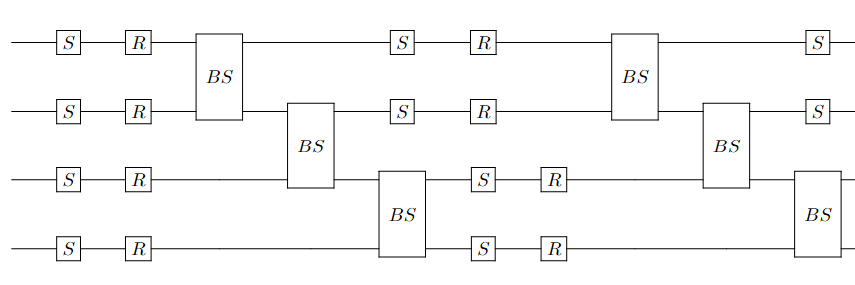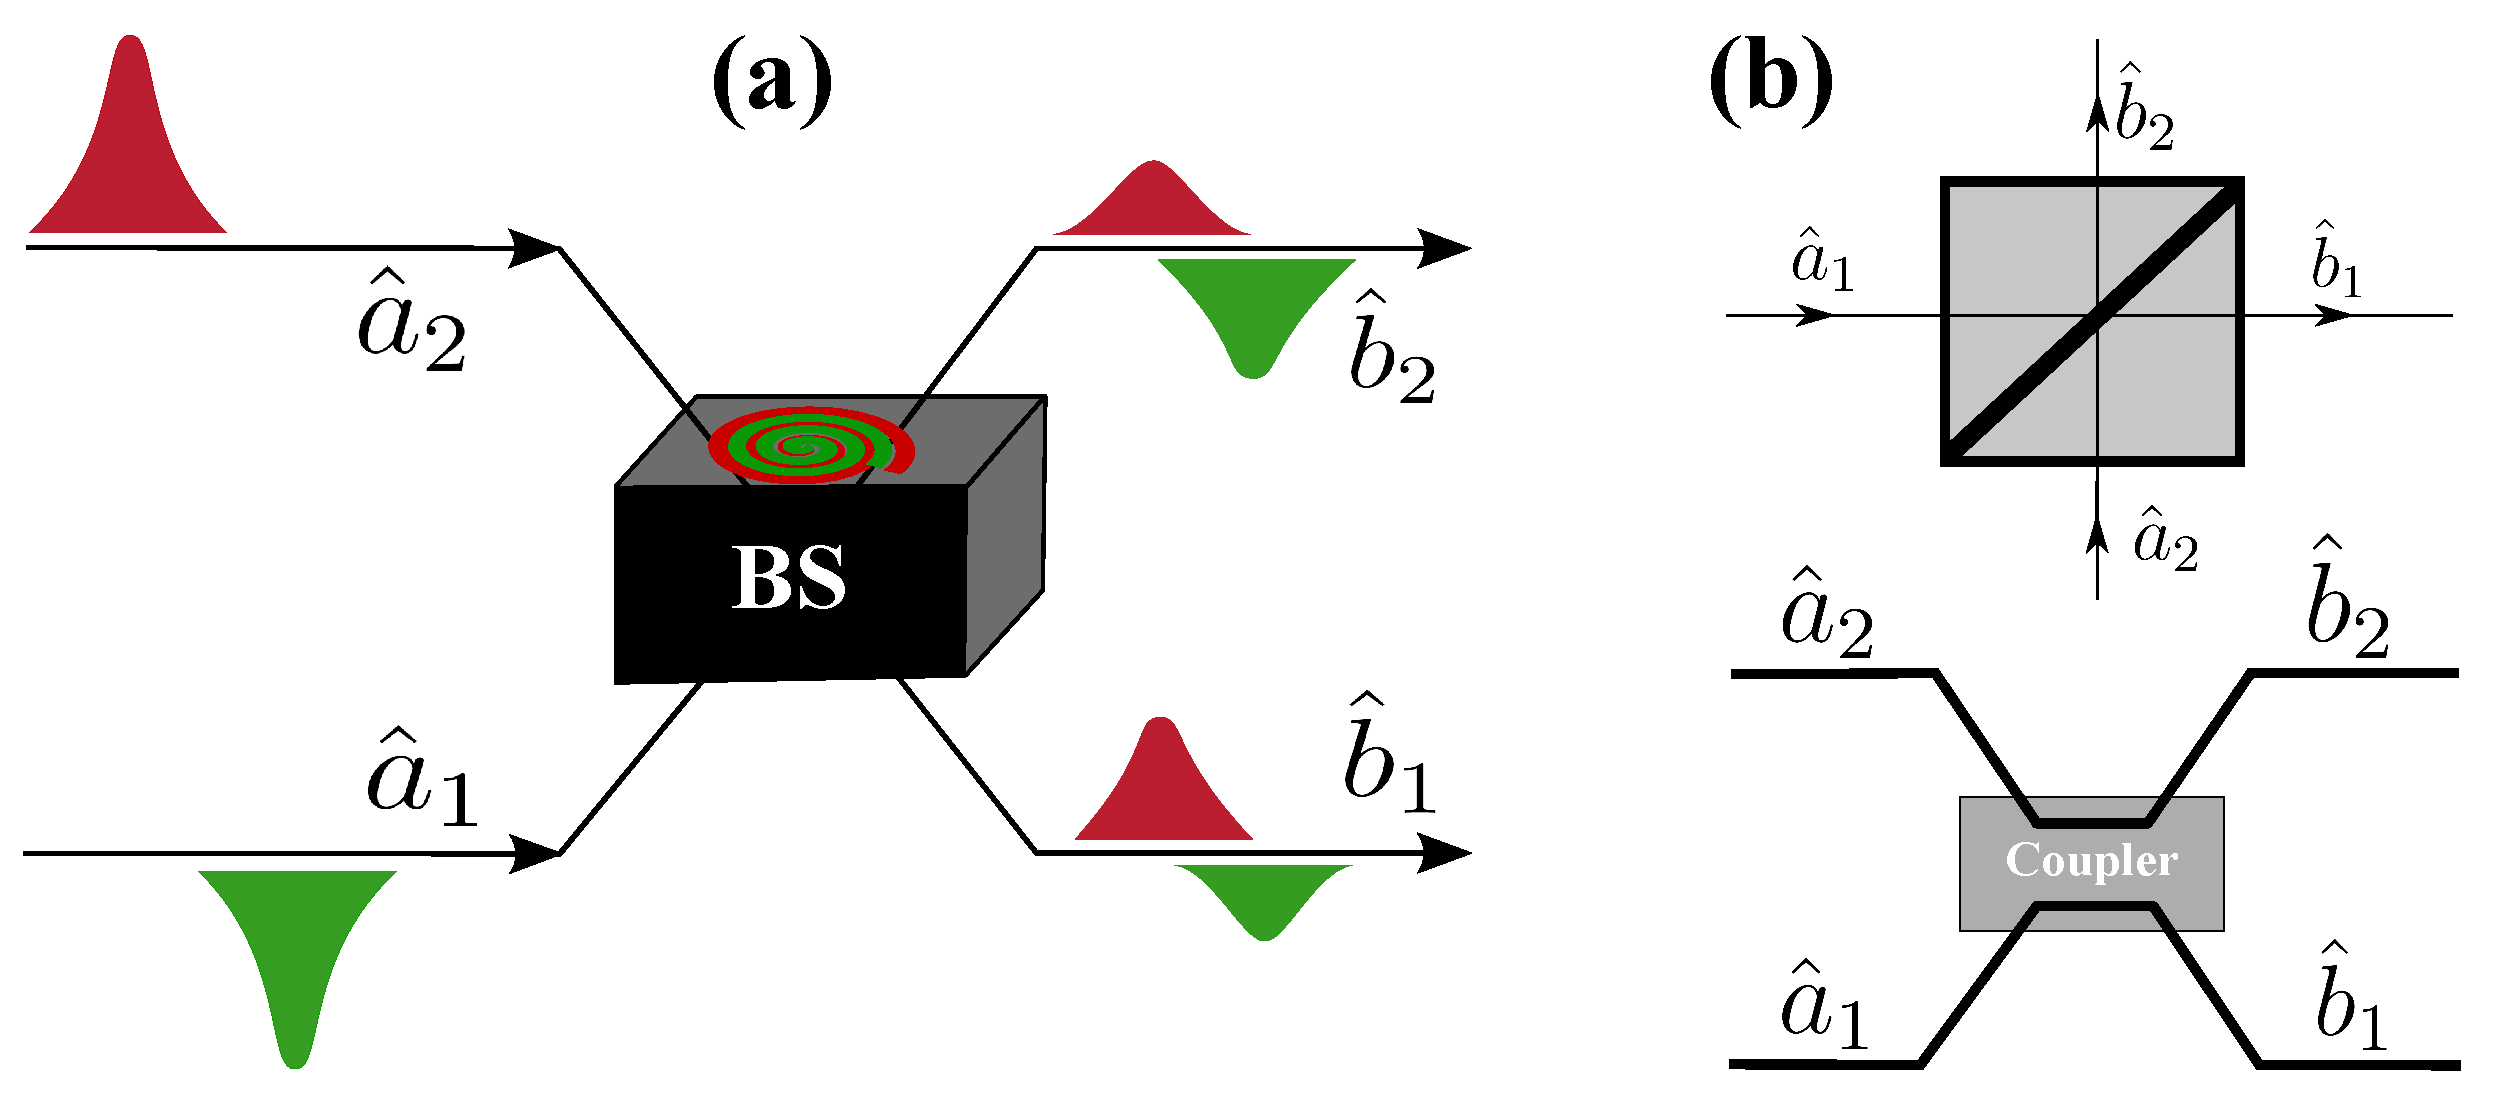

Rep: 0 Cost: 0.9997 Fidelity: 0.0000
Rep: 1 Cost: 0.9184 Fidelity: 0.0067
Rep: 2 Cost: 0.6496 Fidelity: 0.1228
Rep: 3 Cost: 0.3830 Fidelity: 0.3807
Rep: 4 Cost: 0.1662 Fidelity: 0.6952
Rep: 5 Cost: 0.0363 Fidelity: 0.9288
Rep: 6 Cost: 0.0094 Fidelity: 0.9814
Rep: 7 Cost: 0.0183 Fidelity: 0.9638
Rep: 8 Cost: 0.0298 Fidelity: 0.9413
Rep: 9 Cost: 0.0311 Fidelity: 0.9387
Rep: 10 Cost: 0.0281 Fidelity: 0.9447
Rep: 11 Cost: 0.0117 Fidelity: 0.9768
Rep: 12 Cost: 0.0045 Fidelity: 0.9910
Rep: 13 Cost: 0.0021 Fidelity: 0.9959
Rep: 14 Cost: 0.0008 Fidelity: 0.9984
Rep: 15 Cost: 0.0005 Fidelity: 0.9990
Rep: 16 Cost: 0.0004 Fidelity: 0.9991
Rep: 17 Cost: 0.0007 Fidelity: 0.9985
Rep: 18 Cost: 0.0012 Fidelity: 0.9977
Rep: 19 Cost: 0.0019 Fidelity: 0.9962
Rep: 20 Cost: 0.0025 Fidelity: 0.9950
Rep: 21 Cost: 0.0025 Fidelity: 0.9950
Rep: 22 Cost: 0.0022 Fidelity: 0.9956
Rep: 23 Cost: 0.0018 Fidelity: 0.9964
Rep: 24 Cost: 0.0019 Fidelity: 0.9961
Rep: 25 Cost: 0.0036 Fidelity: 0.9928
Rep: 26 Cost: 0.0060 F

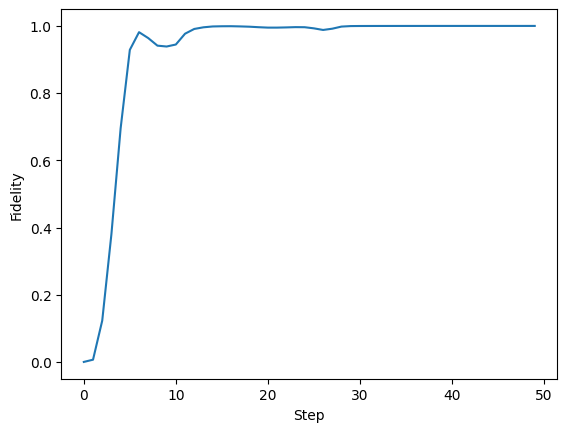

In [ ]:
# squeezing gates
sq1_r = tf.random.normal(shape=[depth], stddev=active_std)
sq2_r = tf.random.normal(shape=[depth], stddev=active_std)
sq3_r = tf.random.normal(shape=[depth], stddev=active_std)
sq4_r = tf.random.normal(shape=[depth], stddev=active_std)
sq1_phi = tf.random.normal(shape=[depth], stddev=passive_std)
sq2_phi = tf.random.normal(shape=[depth], stddev=passive_std)
sq3_phi = tf.random.normal(shape=[depth], stddev=passive_std)
sq4_phi = tf.random.normal(shape=[depth], stddev=passive_std)

# rotation gates
r1 = tf.random.normal(shape=[depth], stddev=std)
r2 = tf.random.normal(shape=[depth], stddev=std)
r3 = tf.random.normal(shape=[depth], stddev=std)
r4 = tf.random.normal(shape=[depth], stddev=std)

# beamsplitter gates
bs1_theta = tf.random.normal(shape=[depth], stddev=std)
bs2_theta = tf.random.normal(shape=[depth], stddev=std)
bs3_theta = tf.random.normal(shape=[depth], stddev=std)
bs1_phi = tf.random.normal(shape=[depth], stddev=passive_std)
bs2_phi = tf.random.normal(shape=[depth], stddev=passive_std)
bs3_phi = tf.random.normal(shape=[depth], stddev=passive_std)

# convert TensorFlow vars representing weights as tensor
weights = tf.convert_to_tensor([sq1_r,sq2_r,sq3_r,sq4_r,sq1_phi,sq2_phi,sq3_phi,sq4_phi,r1,r2,r3,r4,bs1_theta,bs2_theta,bs3_theta,bs1_phi,bs2_phi,bs3_phi])
weights = tf.Variable(tf.transpose(weights))
# print(weights.shape)

# declare 4-mode sf prog
prog = sf.Program(4)

# Create 8 sf free parameters for each layer
sf_params = []
names = ["sq1_r","sq2_r","sq3_r","sq4_r","sq1_phi","sq2_phi","sq3_phi","sq4_phi","r1","r2","r3","r4","bs1_theta","bs2_theta","bs3_theta","bs1_phi","bs2_phi","bs3_phi"]

for i in range(depth):
    sf_params_names = ["{}_{}".format(n,i) for n in names]
    sf_params.append(prog.params(*sf_params_names))

sf_params = np.array(sf_params)
# print(sf_params.shape)

# layer architecture
def layer(i,q):
    for j in range(4):
        Sgate(sf_params[i][j], sf_params[i][j+4]) | q[j]

    for x in range(4):
        Rgate(sf_params[i][x+8]) | q[x]

    for k in range(3):
        BSgate(sf_params[i][k+12],sf_params[i][k+15]) | (q[k],q[k+1])

    return q

ket = np.zeros([cutoff]*4, dtype=np.complex64)
ket[1,0,0,0] = 1.0 + 0.0j

# Apply circuit of layers with corresp. depth
with prog.context as q:
    sf.ops.Ket(ket) | q

    for l in range(depth):
        layer(l,q)

# prog.print()
# prog.draw_circuit()

# instantiate TensorFlow backend, pass Fock basis truncation cutoff
eng = sf.Engine("tf", backend_options={"cutoff_dim":cutoff})

target_state_0 = np.zeros([cutoff])
target_state_0[0] = 1
target_state_1 = np.zeros([cutoff])
target_state_1[0] = 1
target_state_2 = np.zeros([cutoff])
target_state_2[1] = 1
target_state_3 = np.zeros([cutoff])
target_state_3[0] = 1
target_state = tf.cast(np.tensordot(target_state_0,np.tensordot(target_state_1,np.tensordot(target_state_2,target_state_3,0),0),0),tf.complex64)

def cost(weights):
    # Make dict mapping names of sf parms to tf weight values
    mapping ={p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))}
    # Run engine
    state = eng.run(prog,args=mapping).state
    # Extract statevec
    ket = state.ket()
    # Compute fidelity between output and target state
    fidelity = tf.abs(tf.reduce_sum(tf.math.conj(ket)*target_state))**2
    # Obj function to minimize
    # cost = tf.abs(tf.reduce_sum(tf.math.conj(ket)*target_state)-1)
    cost = tf.abs(tf.math.sqrt(fidelity)-1)
    return cost, fidelity, state.reduced_dm(0), state.reduced_dm(2)

# Adam optimizer
# opt = tf.keras.optimizers.Adam(learning_rate=lr)
opt = tf.keras.optimizers.experimental.Nadam(learning_rate=lr)

# get log
tf.get_logger().setLevel('ERROR')

fid_progress = []
best_fid = 0

for i in range(reps): # loop over all reps
    # reset engine if it has been executed
    if eng.run_progs:
        eng.reset()

    with tf.GradientTape() as tape:
        loss, fid, dm0, dm2 = cost(weights)

    # Store fidelity at each step
    fid_progress.append(fid.numpy())

    if fid > best_fid:
        # store new best fid and best state:
        best_fid = fid.numpy()
        dm_0 = dm0
        dm_2 = dm2

    # 1 rep of opt
    gradients = tape.gradient(loss, weights)
    opt.apply_gradients(zip([gradients], [weights]))

    # Print progress each step
    if i % 1 == 0:
        print("Rep: {} Cost: {:.4f} Fidelity: {:.4f}".format(i, loss, fid))

plot_fid(fid_progress)

### Visualizing results

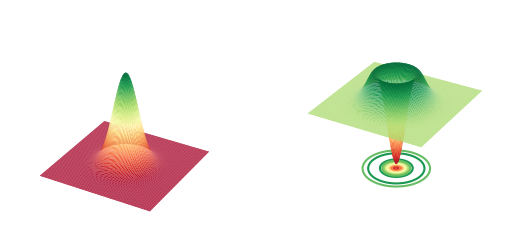

In [ ]:
#@title Target State (modes 1 & 3)

rho_target0 = np.outer(target_state_0, target_state_0.conj())
rho_target2 = np.outer(target_state_2, target_state_2.conj())

fig = plt.figure()
ax1 = fig.add_subplot(121, projection="3d")
X, P, W = wigner(rho_target0)
ax1.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax1.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax1.set_axis_off()
# fig.show()

# fig = plt.figure()
ax2 = fig.add_subplot(122, projection="3d")
X, P, W = wigner(rho_target2)
ax2.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax2.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax2.set_axis_off()
fig.show()

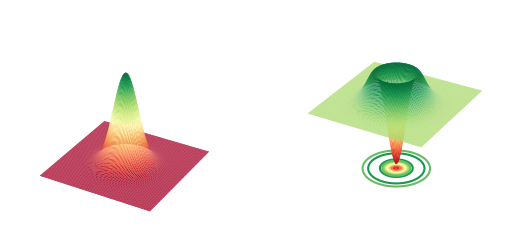

In [ ]:
#@title Learnt State (modes 1 & 3)

fig = plt.figure()
ax1 = fig.add_subplot(121, projection="3d")
X, P, W = wigner(dm_0)
ax1.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax1.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax1.set_axis_off()
# fig.show()

# fig = plt.figure()
ax2 = fig.add_subplot(122, projection="3d")
X, P, W = wigner(dm_2)
ax2.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax2.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax2.set_axis_off()
fig.show()

## Bose-Hubbard Hamiltonian

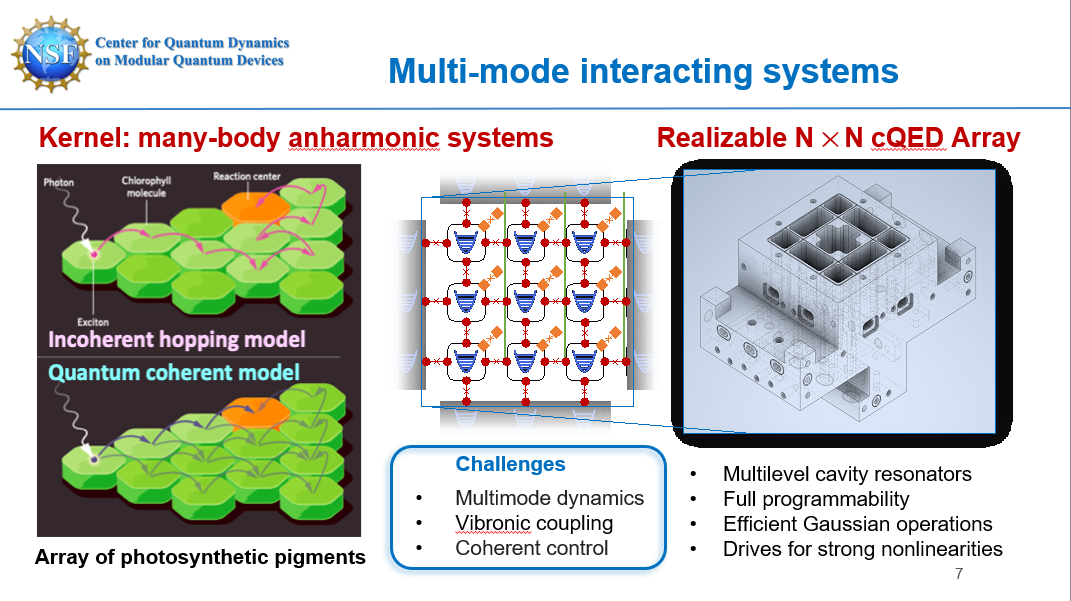

### Simulation

For a pair of two adjacent nodes (corresponding to two qumodes) represented by the adjacency matrix $A = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}$, the Bose-Hubbard Hamiltonian with on-site interactions is given by $$H = J \sum_{i, j} A_{ij}\hat{a}_i^\dagger \hat{a}_j + \frac{1}{2}U \sum_{i} \hat{n}_i(\hat{n}_i-1) = J(\hat{a}_1^\dagger \hat{a}_2 + \hat{a}_2^\dagger \hat{a}_1) + \frac{1}{2}U (\hat{n}_1^2-\hat{n}_1+\hat{n}_2^2-\hat{n}_2)$$ with $J$ being the transfer integral of the boson between nodes and $U$ the on-site interaction potential. We can now write $$e^{-iHt} = \left[\text{exp}\left(-i\frac{Jt}{k}(\hat{a}_1^\dagger\hat{a}_2+\hat{a}_2^\dagger\hat{a}_1)\right)\text{exp}\left(-i\frac{Ut}{2k}\hat{n}_1^2\right)\text{exp}\left(-i\frac{Ut}{2k}\hat{n}_2^2\right)\text{exp}\left(i\frac{Ut}{2k}\hat{n}_1\right)\text{exp}\left(i\frac{Ut}{2k}\hat{n}_2\right)\right]^k + O\left(\frac{t^2}{k}\right) = [BS(\theta,\phi)\left(K(r)R(-r)\otimes K(r)R(-r)\right)]^k + O\left(\frac{t^2}{k}\right)$$ with $\theta=-Jt/k,\phi=\pi/2$, and $r=-Ut/2k$.

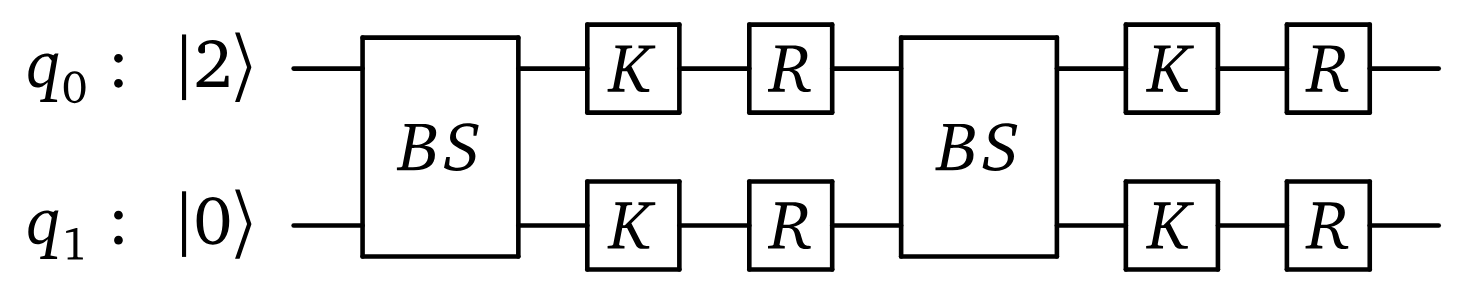

In [ ]:
prog = sf.Program(2)

# set the Hamiltonian parameters

J = 1 # hopping transition
U = 1.5 # on-site interaction
k = 20 # Lie product decomposition ,→ terms, or depth

t = 1.086 # timestep
theta = -J*t/k
r = -U*t/(2*k)
ket = np.zeros([10]*2, dtype=np.complex64)
ket[2,0] = 1.0 + 0.0j

with prog.context as q:
  # prepare the initial state
  Ket(ket) | q

  # Two node tight-binding
  # Hamiltonian simulation

  for i in range(k):
    BSgate(theta, np.pi/2) | (q[0], q[1])
    Kgate(r) | q[0]
    Rgate(-r) | q[0]
    Kgate(r) | q[1]
    Rgate(-r) | q[1]
  # end circuit

# run the engine
eng = sf.Engine('fock', backend_options={"cutoff_dim": 10})
state = eng.run(prog).state

# the output state probabilities
print(state.fock_prob([0,2]))
print(state.fock_prob([1,1]))
print(state.fock_prob([2,0]))

0.5224012457200212
0.23565287685672495
0.24194587742326018


In order to calculate energy $E=\frac{\langle\psi|H|\psi\rangle}{\langle\psi|\psi\rangle}$ of output statevector $|\psi\rangle$, we need to compute the expectation value of $H = J(\hat{a}_1^\dagger \hat{a}_2 + \hat{a}_2^\dagger \hat{a}_1) + \frac{1}{2}U (\hat{n}_1^2-\hat{n}_1+\hat{n}_2^2-\hat{n}_2) = \hat{J} + \frac{1}{2}\hat{U}$.

Now note that, with the notation $|\psi\rangle = \sum_i^{10}\sum_j^{10} c_{i,j} |i,j\rangle$,


*   $\langle\psi|\hat{a}_1^\dagger\hat{a}_2|\psi\rangle = \left(\sum_i^{10}\sum_j^{10} c_{i,j}^* \langle i,j|\right)\left(\sum_{i'}^{10}\sum_{j'}^{10} c_{i',j'} \sqrt{j'(i'+1)} |i'+1,j'-1\rangle\right) = \sum_i^{10}\sum_j^{10} c_{i,j}^* \sqrt{i(j+1)} c_{i-1,j+1}$. Similarly, $$\langle\psi|\hat{J}|\psi\rangle = \sum_i^{10}\sum_j^{10} c_{i,j}^* \left(\sqrt{i(j+1)} c_{i-1,j+1}+\sqrt{j(i+1)} c_{i+1,j-1}\right)$$
*   On the other hand, $\langle\psi|\hat{n}_1|\psi\rangle = \left(\sum_i^{10}\sum_j^{10} c_{i,j}^* \langle i,j|\right)\left(\sum_{i'}^{10}\sum_{j'}^{10} c_{i',j'} i |i',j'\rangle\right) = \sum_i^{10}\sum_j^{10} i |c_{i,j}|^2$ and $\langle\psi|\hat{n}_1^2|\psi\rangle = \sum_i^{10}\sum_j^{10} i^2 |c_{i,j}|^2$. Hence, $$\langle \psi|\frac{1}{2}\hat{U}|\psi\rangle = \frac{1}{2}\sum_i^{10}\sum_j^{10} |c_{i,j}|^2 (i^2+j^2-i-j) $$

The functions *hopping_term* and *on_site* below calculates the expectation values of $\hat{J}$ and $\frac{1}{2}\hat{U}$ as described.

In [ ]:
Fock_cut = 10
# hopping term and on-site calculation
def hopping_term(statevec):
    svc = np.conj(statevec)
    hop = 0
    for i in range(Fock_cut):
        if i == 0:
            for j in range(1,Fock_cut):
                hop += (svc[i,j]*np.sqrt((i+1)*j)*statevec[i+1,j-1])
        else:
            for j in range(Fock_cut-1):
                hop += (svc[i,j]*np.sqrt(i*(j+1))*statevec[i-1,j+1])
            if i < Fock_cut-1:
                for x in range(1,Fock_cut):
                    hop += (svc[i,x]*np.sqrt((i+1)*x)*statevec[i+1,x-1])
    return np.abs(hop*J)

def on_site(statevec):
    on_site = 0
    for i in range(Fock_cut):
        for j in range(Fock_cut):
            on_site += np.abs(statevec[i,j])*(i**2+j**2-i-j)
    return np.abs(on_site*U/2)

sket = state.ket()
inner_prod = np.abs(np.vdot(sket,sket))
energy = (hopping_term(sket)+on_site(sket))/inner_prod
print(energy)

2.135642775045301


### VQE to minimize energy by varying only the circuit parameters

In [ ]:
bose_hubbard_ham = sf.Program(2)
Fock_cut = 10
# randomize parameters, centered at theta and r as defined above
theta1 = tf.random.normal(shape=[depth], mean = -0.05, stddev=0.01)
phi1 = tf.random.normal(shape=[depth], mean = np.pi/2, stddev=0.01)
kappa1 = tf.random.normal(shape=[depth], mean = -0.05, stddev=0.01)
kappa2 = tf.random.normal(shape=[depth], mean = -0.05, stddev=0.01)
r1 = tf.random.normal(shape=[depth], mean = 0.05, stddev=0.01)
r2 = tf.random.normal(shape=[depth], mean = 0.05, stddev=0.01)

# convert TensorFlow vars representing weights as tensor
weights = tf.convert_to_tensor([theta1,phi1,kappa1,kappa2,r1,r2])
weights = tf.Variable(tf.transpose(weights))

# Create 8 sf free parameters for each layer
sf_params = []
names = ["theta1","phi1","kappa1","kappa2","r1","r2"]

for i in range(depth):
    sf_params_names = ["{}_{}".format(n,i) for n in names]
    sf_params.append(bose_hubbard_ham.params(*sf_params_names))

sf_params = np.array(sf_params)

ket = np.zeros([10]*2, dtype=np.complex64)
ket[2,0] = 1.0 + 0.0j

def layer(i,q):
    for y in range(1):
        BSgate(sf_params[i][y],sf_params[i][y+1]) | (q[y],q[y+1])

    for z in range(1):
        Kgate(sf_params[i][z+2]) | q[z]
        Kgate(sf_params[i][z+3]) | q[z+1]
        Rgate(sf_params[i][z+4]) | q[z]
        Rgate(sf_params[i][z+5]) | q[z+1]

with bose_hubbard_ham.context as q:
  # prepare the initial state
  Ket(ket) | q

  # Two node tight-binding
  # Hamiltonian simulation

  for l in range(depth):
        layer(l,q)
  # end circuit

# bose_hubbard_ham.print()

# run the engine
eng = sf.Engine('tf', backend_options={"cutoff_dim": Fock_cut})

In [ ]:
# Create cost function
def energy_calculate(weights):
    # Make dict mapping names of sf parms to tf weight values
    mapping ={p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))}
    # Run engine
    state = eng.run(bose_hubbard_ham,args=mapping).state
    # Extract statevec
    sket = state.ket()
    # Compute energy/expectation value of output
    inner_prod = tf.experimental.numpy.vdot(sket,sket)
    energy = tf.math.real((hopping_term(sket)+on_site(sket))/inner_prod)
     # hopping term
    return energy, sket

Rep: 0 Energy: 1.6799
Rep: 1 Energy: 1.7308
Rep: 2 Energy: 1.7431
Rep: 3 Energy: 1.7451
Rep: 4 Energy: 1.7462
Rep: 5 Energy: 1.7571
Rep: 6 Energy: 1.7629
Rep: 7 Energy: 1.7746
Rep: 8 Energy: 1.7807
Rep: 9 Energy: 1.7884
Rep: 10 Energy: 1.7903
Rep: 11 Energy: 1.7796
Rep: 12 Energy: 1.7806
Rep: 13 Energy: 1.7699
Rep: 14 Energy: 1.7462
Rep: 15 Energy: 1.7862
Rep: 16 Energy: 1.8068
Rep: 17 Energy: 1.8037
Rep: 18 Energy: 1.8063
Rep: 19 Energy: 1.8141
Rep: 20 Energy: 1.8291
Rep: 21 Energy: 1.7973
Rep: 22 Energy: 1.7648
Rep: 23 Energy: 1.7722
Rep: 24 Energy: 1.7889
Rep: 25 Energy: 1.7666
Rep: 26 Energy: 1.7623
Rep: 27 Energy: 1.7600
Rep: 28 Energy: 1.7586
Rep: 29 Energy: 1.7396
Rep: 30 Energy: 1.7321
Rep: 31 Energy: 1.7226
Rep: 32 Energy: 1.7355
Rep: 33 Energy: 1.7220
Rep: 34 Energy: 1.7027
Rep: 35 Energy: 1.7119
Rep: 36 Energy: 1.6987
Rep: 37 Energy: 1.6790
Rep: 38 Energy: 1.6644
Rep: 39 Energy: 1.6490
Rep: 40 Energy: 1.6494
Rep: 41 Energy: 1.6453
Rep: 42 Energy: 1.6423
Rep: 43 Energy: 1.635

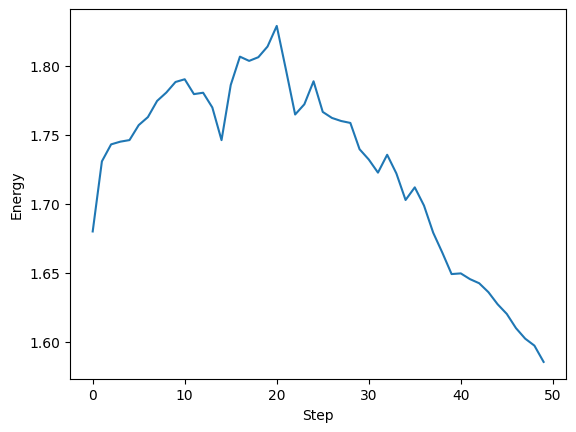

In [ ]:
# Adam optimizer
# opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
opt = tf.keras.optimizers.experimental.Nadam(learning_rate=0.005)

# get log
tf.get_logger().setLevel('ERROR')

E_progress = []
lowest_energy = 1e2 # an arbitrarily large number
reps = 50

for i in range(reps): # loop over all reps
    # reset engine if it has been executed
    if eng.run_progs:
        eng.reset()

    with tf.GradientTape() as tape:
        energy, ket = energy_calculate(weights)

    # Store E at each step
    E_progress.append(energy)

    if energy < lowest_energy:
        # store new best E and best state:
        lowest_energy = energy
        learnt_state = ket
        best_parm = weights.numpy()

    # 1 rep of opt
    gradients = tape.gradient(energy, weights)
    opt.apply_gradients(zip([gradients], [weights]))

    # Print progress each step
    if i % 1 == 0:
        print("Rep: {} Energy: {:.4f}".format(i, energy))

plot_energy(E_progress)

In [ ]:
print(best_parm)

[[-0.10351559  1.5519186  -0.05768891 -0.03775273  0.05045941  0.03798926]
 [-0.09496127  1.5663507  -0.03296436 -0.06622931  0.06111696  0.0285814 ]
 [-0.08379449  1.578609   -0.02705633 -0.0483572   0.06548696  0.02959074]
 [-0.11732746  1.5859374  -0.02518008 -0.05473083  0.00421166  0.04974589]]


### VQE to minimize energy by varying J and U, fixing the phase angle of beamsplitter at $\phi=\frac{\pi}{2}$

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/constant_op.py:103: ComplexWarning: Casting complex values to real discards the imaginary part


Rep: 0 Energy: 2.4794
Rep: 1 Energy: 2.4686
Rep: 2 Energy: 2.4621
Rep: 3 Energy: 2.4507
Rep: 4 Energy: 2.4483
Rep: 5 Energy: 2.4468
Rep: 6 Energy: 2.4398
Rep: 7 Energy: 2.4339
Rep: 8 Energy: 2.4267
Rep: 9 Energy: 2.4111
Rep: 10 Energy: 2.4045
Rep: 11 Energy: 2.3940
Rep: 12 Energy: 2.3872
Rep: 13 Energy: 2.3756
Rep: 14 Energy: 2.3680
Rep: 15 Energy: 2.3486
Rep: 16 Energy: 2.3425
Rep: 17 Energy: 2.3275
Rep: 18 Energy: 2.3074
Rep: 19 Energy: 2.2979
Rep: 20 Energy: 2.2903
Rep: 21 Energy: 2.2741
Rep: 22 Energy: 2.2537
Rep: 23 Energy: 2.2480
Rep: 24 Energy: 2.2392
Rep: 25 Energy: 2.2310
Rep: 26 Energy: 2.2249
Rep: 27 Energy: 2.2007
Rep: 28 Energy: 2.1893
Rep: 29 Energy: 2.1685
Rep: 30 Energy: 2.1587
Rep: 31 Energy: 2.1467
Rep: 32 Energy: 2.1336
Rep: 33 Energy: 2.1187
Rep: 34 Energy: 2.0967
Rep: 35 Energy: 2.0843
Rep: 36 Energy: 2.0763
Rep: 37 Energy: 2.0522
Rep: 38 Energy: 2.0300
Rep: 39 Energy: 2.0110
Rep: 40 Energy: 1.9983
Rep: 41 Energy: 1.9840
Rep: 42 Energy: 1.9718
Rep: 43 Energy: 1.960

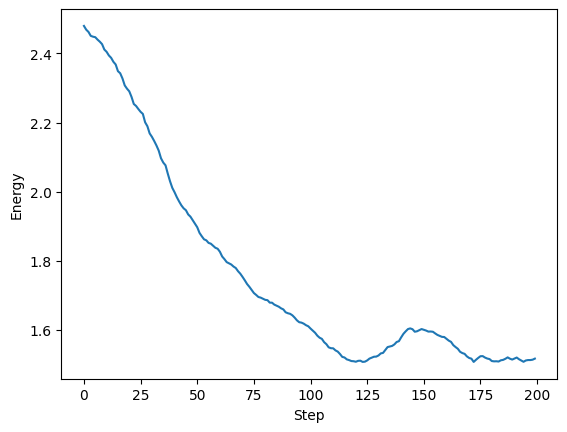

In [ ]:
bose_hubbard_ham2 = sf.Program(2)
Fock_cut = 10
# randomize parameters, centered at theta and r as defined above
J = tf.random.normal(shape = [1], mean = 1, stddev=0.01)
U = tf.random.normal(shape = [1], mean = 1.5, stddev=0.01)
k = 1 # Lie product decomposition ,→ terms, or depth. Change to 20 later
t = 1.086 # timestep
theta2 = -J*t/k
r_calc = -U*t/(2*k)

# convert TensorFlow vars representing weights as tensor
weights = tf.convert_to_tensor([theta2,r_calc])
weights = tf.Variable(tf.transpose(weights))

# Create 8 sf free parameters for each layer
sf_params = []
names = ["theta2","r_calc"]

for i in range(k):
    sf_params_names = ["{}_{}".format(n,i) for n in names]
    sf_params.append(bose_hubbard_ham2.params(*sf_params_names))

sf_params = np.array(sf_params)

ket = np.zeros([10]*2, dtype=np.complex64)
ket[2,0] = 1.0 + 0.0j

def layer(i,q):
    for y in range(1):
        BSgate(sf_params[i][y],np.pi/2) | (q[y],q[y+1])

    for z in range(1):
        Kgate(sf_params[i][z+1]) | q[z]
        Kgate(sf_params[i][z+1]) | q[z+1]
        Rgate(-sf_params[i][z+1]) | q[z]
        Rgate(-sf_params[i][z+1]) | q[z+1]

with bose_hubbard_ham2.context as q:
  # prepare the initial state
  Ket(ket) | q

  # Two node tight-binding
  # Hamiltonian simulation

  for l in range(k):
        layer(l,q)
  # end circuit

# bose_hubbard_ham2.print()

# run the engine
eng = sf.Engine('tf', backend_options={"cutoff_dim": Fock_cut})

# Create cost function
def energy_calculate2(weights):
    # Make dict mapping names of sf parms to tf weight values
    mapping ={p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))}
    # Run engine
    state = eng.run(bose_hubbard_ham2,args=mapping).state
    # Extract statevec
    sket = state.ket()
    # Compute energy/expectation value of output
    inner_prod = tf.experimental.numpy.vdot(sket,sket)
    energy = (hopping_term(sket.numpy())+on_site(sket.numpy()))/inner_prod
     # hopping term
    return tf.math.real(energy), sket

# Adam optimizer
# opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
opt = tf.keras.optimizers.experimental.Nadam(learning_rate=0.01)

# get log
tf.get_logger().setLevel('ERROR')

E_progress = []
lowest_energy = 1e2 # an arbitrarily large number
reps = 200

for i in range(reps): # loop over all reps
    # reset engine if it has been executed
    if eng.run_progs:
        eng.reset()

    with tf.GradientTape() as tape:
        energy, ket = energy_calculate2(weights)

    # Store E at each step
    E_progress.append(energy)

    if energy < lowest_energy:
        # store new best E and best state:
        lowest_energy = energy
        learnt_state = ket
        best_parm = weights.numpy()

    # 1 rep of opt
    gradients = tape.gradient(energy, weights)
    opt.apply_gradients(zip([gradients], [weights]))

    # Print progress each step
    if i % 1 == 0:
        print("Rep: {} Energy: {:.4f}".format(i, energy[0]))

plot_energy(E_progress)

In [ ]:
print(lowest_energy.numpy()[0], -best_parm[0,0]*k/t, -best_parm[0,1]*2*k/t) # values of lowest energy, optimized J and U

1.5076997 0.7229906748671557 1.2292517263366811


## Kerr-Cat Oscillator

The Kerr oscillator, studied in [[1]](http://ursula.chem.yale.edu/~batista/NSF_CenterQuantumDynamics_ModularQuantumDevices/publications/publications_pdf_files/spectral_kissing_dynamics_squeezed_Kerr_oscillator.pdf) and [[2]](http://ursula.chem.yale.edu/~batista/NSF_CenterQuantumDynamics_ModularQuantumDevices/publications/publications_pdf_files/tunneling_crossings_Kerr_oscillator.pdf), whose dynamics is described by the Hamiltonian $$\frac{\hat{H}}{\hbar K_{err}} = \hat{n} (\hat{n}-1) - \zeta (\hat{a}^2+{\hat{a}^\dagger}^2)$$ with the parameter values taken from [[1]](http://ursula.chem.yale.edu/~batista/NSF_CenterQuantumDynamics_ModularQuantumDevices/publications/publications_pdf_files/spectral_kissing_dynamics_squeezed_Kerr_oscillator.pdf): $\zeta=\frac{\epsilon}{K_{err}}=4$ and $\frac{K_{err}}{2 \pi}= 0.32~\text{MHz}$.

For a time-step $\tau=t/(\hbar K_{err})$, we approximate the time-evolution operator with big enough number of layers $k$, as follows:
$$e^{-\frac{i}{\hbar} H \tau} \approx \left[e^{-\frac{i t}{\hbar k} \hat{n}^2} e^{\frac{i t}{\hbar k} \hat{n}} e^{\frac{i \zeta t}{\hbar k} ({\hat{a}^\dagger}^2+\hat{a}^2)} \right]^k + \mathcal{O}(t^2/k)$$.

Therefore, $$e^{-\frac{i}{\hbar} H \tau} \approx [K(-r) R(r)S(z)]^k + \mathcal{O}(t^2/k),$$

Here, $R(r) = e^{i r \hat{n}}$, and $K(-r) = e^{-i r \hat{n}^2}$, with $r=\frac{t}{\hbar k}$, while  $S(z) = e^{(z^* \hat{a}^2 - z {\hat{a}^\dagger}^2)/2}$, with $z=-i r 2 \zeta = \vert z \vert e^{i \phi}$ where $\vert z \vert = r 2 \zeta$ and $\phi = - \pi/2$.

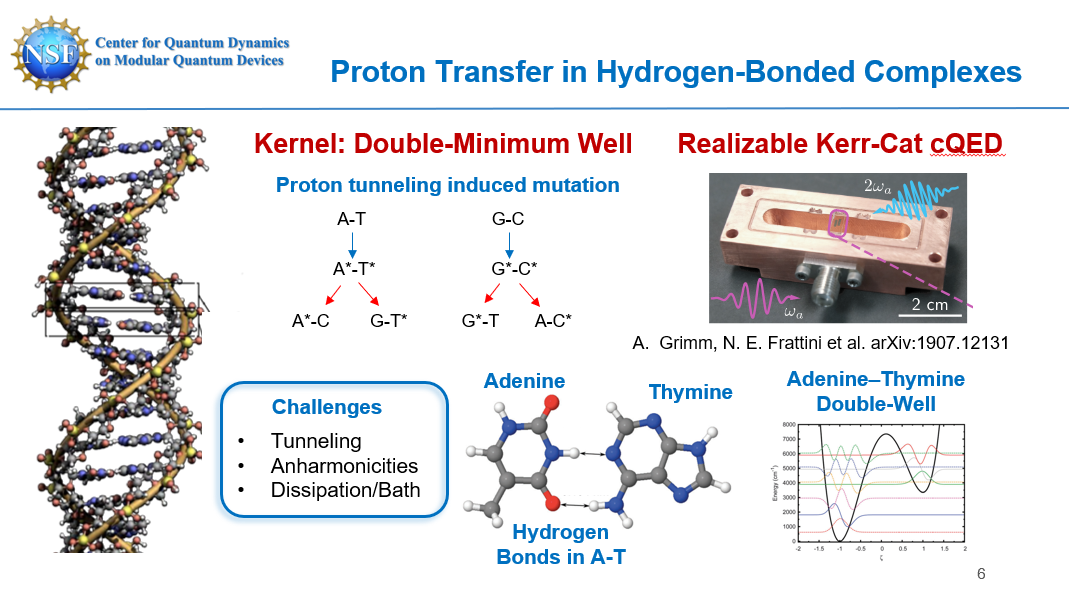

In [ ]:
#@title Import packages for later visualization
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, animation
from base64 import b64encode
from IPython.display import HTML

In [ ]:
#@title Define function that runs the desired circuit
import strawberryfields.decompositions
from strawberryfields.decompositions import *

def split_rho(k, out=np.array([1,0,0,0,0,0,0,0])):
  prog = sf.Program(1)

  r = 0.05*10/200
  zeta = 4
  z = -2*zeta*r*1j

  with prog.context as q:
    # prepare the initial state
    sf.ops.Ket(out) | q[0]

    # Propagation
    for i in range(k):
      Rgate(r) | q[0]
      Sgate(z) | q[0]
      Kgate(-r) | q[0]

    # end circuit

  # run the engine
  eng = sf.Engine('fock', backend_options={"cutoff_dim": 8})
  state = eng.run(prog).state
  return state, state.ket()

### Husimi distribution

The Husimi distribution is the Weierstrass transform of the Wigner distribution, as follows: $$Q(\alpha) = \frac{2}{\pi} \int W(\beta) e^{-2\vert \alpha -\beta \vert^2} d^2\beta$$

In [ ]:
# Gaussian Kernel to obtain the Husimi distribution as the Gaussian convolution of the Wigner transform
from scipy.signal import convolve2d
npt=100
X = np.linspace(-10, 10, npt)
P = np.linspace(-10, 10, npt)
state, out = split_rho(0)
W = state.wigner(0, X, P)
Kern = np.empty_like(W)
for i in range(np.size(X)):
  for j in range(np.size(P)):
    diff=np.abs((X[i]+1j*P[j])/np.sqrt(2))
    Kern[j,i]=np.exp(-2*diff**2)*(X[1]-X[0])*(P[1]-P[0])/np.pi

In [ ]:
cb = None

def plot_result2(n, fig=None, axes=None):
    global cb
    xmin = -5
    xmax = 5
    axes.cla()

    X = np.linspace(xmin, xmax, npt)
    P = np.linspace(xmin, xmax, npt)
    state, out = split_rho(n)
    W = state.wigner(0, X, P)

    # For Husimi distribution
    W = convolve2d(W,Kern, boundary='symm', mode='same')

    X, P = np.meshgrid(X, P)

    surf = axes.plot_surface(X, P, W, rstride=1, cstride=1, cmap=cm.jet,
                              alpha=0.75, linewidth=0.05, vmax=0.25, vmin=-0.25)
    axes.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
    axes.set_xlim3d(xmin, xmax)
    axes.set_ylim3d(xmin, xmax)
    axes.set_zlim3d(-0.25, 0.25)
    if not cb:
        cb = plt.colorbar(surf, shrink=0.65, aspect=20)
    return axes.artists


def update2(n=1):
    return plot_result2(n, fig=fig, axes=ax)

In [ ]:
name = 'SF-Surface-Animation'
# Set-up the figure
fig = plt.figure(figsize=(8, 4), dpi=100)
# Create 3D axes, add to figure
ax = Axes3D(fig, azim=-107, elev=29)
fig.add_axes(ax, projection='3D')
# Create animation object and run routine to save to a .mp4 file
anim = animation.FuncAnimation(fig, update2, frames=200, blit=True)
anim.save(name + '.mp4', fps=10, writer="ffmpeg", codec=None)
plt.close(fig)
# Open Video and display in notebook by converting to HTML with base64
video = open(name + '.mp4', "rb").read()
video_encoded = b64encode(video).decode("ascii")
video_tag = '<video controls src="data:video/x-m4v;base64,{0}" height=720px>'.format(video_encoded) # Set the height to rescale the output.
HTML(video_tag)

### Numerical inverse Wigner transform

[ 0.84789052+0.21355027j  0.        +0.j          0.21973432-0.47178096j  0.        +0.j
 -0.28288598-0.08854669j  0.        +0.j         -0.23554051+0.02302036j  0.        +0.j        ]


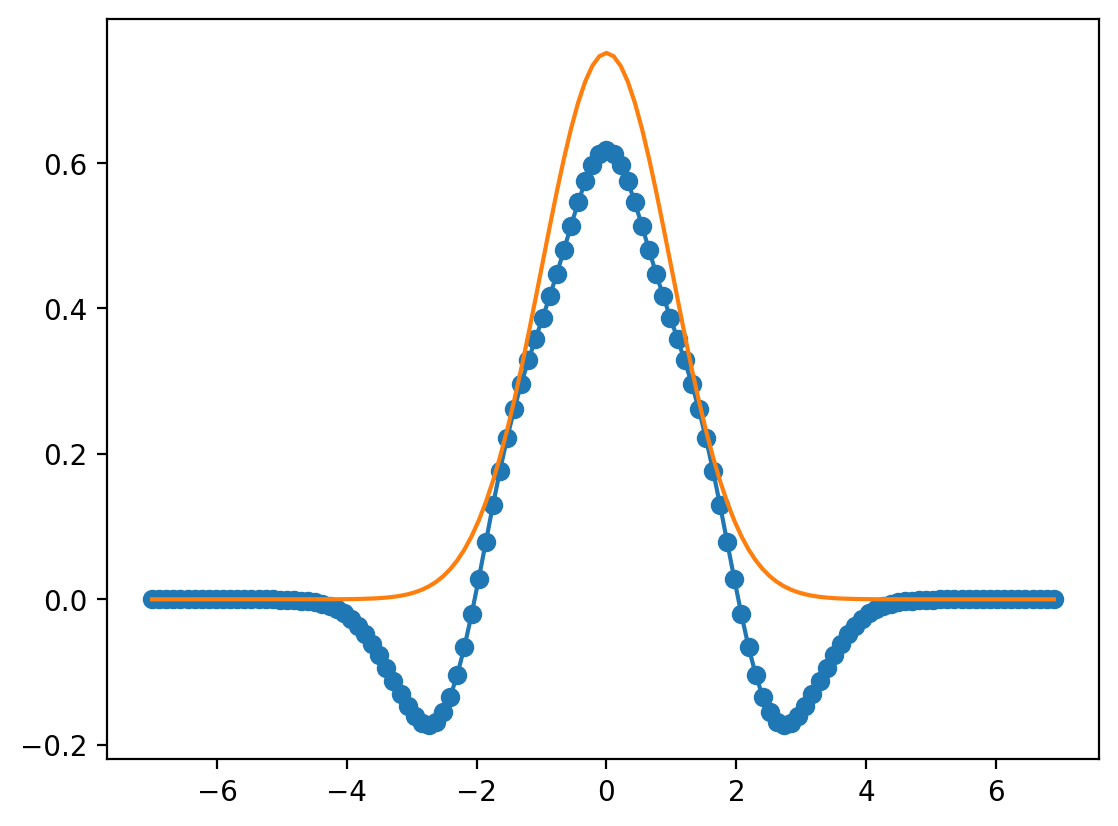

In [ ]:
xmin = -7.0
xmax = 7.0
N = 128

dp = 2.0*np.pi/(xmax-xmin)*0.5
pv=np.arange(-N/2,N/2)*dp
dx=(xmax-xmin)/N
xvec=np.arange(-N/2,N/2)*dx

def psirv4(n):
  state, out = split_rho(1)
  for j in range(1,n):
    state, out = split_rho(1, out)
  wt=state.wigner(0,xvec/2,pv)
  print(state.ket())
  out=np.zeros(np.size(xvec),dtype=complex)
  for k in range(np.size(xvec)):
    for j in range(np.size(pv)):
      out[k]+=dp*np.exp(1j*pv[j]*xvec[k])*wt[j,k]
  fo=np.sqrt(np.linalg.norm(out)**2*dx)
  return out/fo

plt.plot(xvec,np.real(psirv4(150)),'-o')

ref=np.exp(-xvec**2/2)/(np.pi)**0.25
plt.plot(xvec,np.real(ref),'-')

### Simulation with Qiskit

#### Code

In [ ]:
!pip install qutip
import matplotlib.pyplot as plt
import qutip as qt
from qutip import *

from pylab import *
import matplotlib as mpl

import imageio
import matplotlib.image as mpimg
from matplotlib import cm, animation
from mpl_toolkits.mplot3d import Axes3D

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 100

!pip install qiskit
!pip install pylatexenc

from qiskit import *
import numpy as np
from matplotlib import pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
import pylatexenc

from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumCircuit, QuantumRegister
#import prepare_MPS as mps
from qiskit import BasicAer, execute
import matplotlib
from matplotlib import axes
import itertools
import scipy.linalg as spLA
import matplotlib.pyplot as plt
from tqdm.notebook import trange
np.set_printoptions(linewidth=110)

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import BasicAer, execute
from qiskit.compiler import transpile
from qiskit.opflow import X, Y, Z, I, One, Zero, PauliOp, PauliSumOp, Suzuki
from qiskit.opflow.evolutions import PauliTrotterEvolution
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity
from qiskit.extensions import RXGate, XGate, CXGate
from qiskit.circuit import Parameter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 56.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 99.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

<ipython-input-9-968e9aa45eaf>:47: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.


In [ ]:

#------------ Utility Functions ------------#

def vec_query(arr, my_dict):
    '''
    This function vectorizes dictionary querying, allowing us to query `my_dict` with a np.array `arr` of keys.
    '''

    return np.vectorize(my_dict.__getitem__, otypes=[tuple])(arr)

def nested_kronecker_product(a):
    '''
    Handles Kronecker Products for list (i.e.,  a = [Z, Z, Z] will evaluate Z ⊗ Z ⊗ Z)
    '''
    if len(a) == 2:
            return np.kron(a[0],a[1])
    else:
        return np.kron(a[0], nested_kronecker_product(a[1:]))

def Hilbert_Schmidt(mat1, mat2):
    # |ψ1> and |ψ2>: <ψ1*|ψ2> for <ψ1|*
    return np.trace(mat1@ mat2)

def decompose(H, verbose=False):
    #define the four Pauli-matrices in a dictionary:
    pms = { 'I': np.array([[1, 0], [0, 1]], dtype=complex),
             'X': np.array([[0, 1], [1, 0]], dtype=complex),
             'Y': np.array([[0, -1j], [1j, 0]], dtype=complex),
            'Z': np.array([[1, 0], [0, -1]], dtype=complex)}
    if verbose:
        print('Terms of the Operator:\n')
    pauli_keys = list(pms.keys()) # Grab Matrix Names for printing
    nqb = int(np.log2(H.shape[0])) # Get the number of qubits needed for our pauli strings
    output_string = ''
    sigma_combinations = list(itertools.product(pauli_keys, repeat=nqb))    # Gives all possible combinations of nqb Pa

    for ii in trange(len(sigma_combinations)):
        name = sigma_combinations[ii][0]
        for ll in range(1, len(sigma_combinations[ii])):
            name = name + '⊗' + sigma_combinations[ii][ll]
        alt_name = ''.join(sigma_combinations[ii]) # For tequila compatibility
        a_ij = (1/(2**nqb)) * Hilbert_Schmidt(nested_kronecker_product(vec_query(np.array(sigma_combinations[ii]), pms)), H)
        # If the Hilbert-Schmidt Product doesn't reduce to 0
        if a_ij != 0.0:
            if abs(a_ij) < 1e-10:
                pass
            else:
                if verbose:
                    print(np.round(a_ij.real, 6),'', name)
                output_string += str(np.round(a_ij.real, 6))+'*'+alt_name
                output_string += '+'
    return output_string[:-1] # To ignore that extra plus sign


def build_pauli_dict(decomposed_operator):
    single_terms = decomposed_operator.split('+')
    pauli_dict_out = {}
    for term in single_terms:
        coeff, pauli_str = term.split('*')
        pauli_dict_out[pauli_str] = float(coeff)
    return pauli_dict_out


def pauli_strings_2_pauli_sum(operator):
    tmp_pauli_dict = build_pauli_dict(operator)
    # Convert the dict to a list of tuples of the form [('Pauli String', float_coeff), ...]
    tmp_pauli_list = list(zip(tmp_pauli_dict.keys(), tmp_pauli_dict.values()))
    # Construct a qiskit PauliSumOp from this list
    tmp_pauli_sum = PauliSumOp.from_list(tmp_pauli_list)
    return tmp_pauli_sum

In [ ]:
#global result2
occ=16
r=0.05
zeta=4
#z=-2*zeta*r*1j
crea=create(occ)
dest=destroy(occ)

numoc=crea*dest
ham=numoc*(numoc-qutip.qeye(occ))-zeta*(crea**2+dest**2)
ham=ham*r

#k=5
psi0=fock(occ,0)
#H_ho = hbar*omga*(a.dag()*a + 1./2.)                            # Harmonic Oscillator Hamiltonian
tlist = np.linspace(0, 10, 200)   # Define the list of times for which we calculate dynamics.
result2 = qt.mesolve(ham, psi0, tlist, [], [], progress_bar=True)

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.01s. Est. time left: 00:00:00:00
30.0%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.02s. Est. time left: 00:00:00:00
50.0%. Run time:   0.02s. Est. time left: 00:00:00:00
60.0%. Run time:   0.02s. Est. time left: 00:00:00:00
70.0%. Run time:   0.03s. Est. time left: 00:00:00:00
80.0%. Run time:   0.03s. Est. time left: 00:00:00:00
90.0%. Run time:   0.03s. Est. time left: 00:00:00:00
Total run time:   0.04s


In [ ]:
decomposed_xmd = decompose(ham.full(), verbose=False)
circ_h = pauli_strings_2_pauli_sum(decomposed_xmd)
time_step = Parameter('t')
U_h = (time_step*circ_h).exp_i()
tU_h = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=1)).convert(U_h)

  0%|          | 0/256 [00:00<?, ?it/s]

<ipython-input-12-14d28420c87f>:5: DeprecationWarning: The class ``qiskit.opflow.evolutions.trotterizations.suzuki.Suzuki`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
<ipython-input-12-14d28420c87f>:5: DeprecationWarning: The class ``qiskit.opflow.evolutions.pauli_trotter_evolution.PauliTrotterEvolution`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.


In [ ]:
xmin = -7.0
xmax = 7.0
N = 128

dp = 2.0*np.pi/(xmax-xmin)*0.5
pv=np.arange(-N/2,N/2)*dp
dx=(xmax-xmin)/N
xvec=np.arange(-N/2,N/2)*dx


X, Y = np.meshgrid(xvec, xvec)
global psin,qc2
tlist = np.linspace(0, 10, 200)
dt=(tlist[1]-tlist[0])
# circuit for one propagation step
qc2=tU_h.bind_parameters({time_step: dt})
#initial state
d=4
n=2**d
psi0=fock(n)
psin=psi0.full()
psin=psin.flatten()

#### Visualization

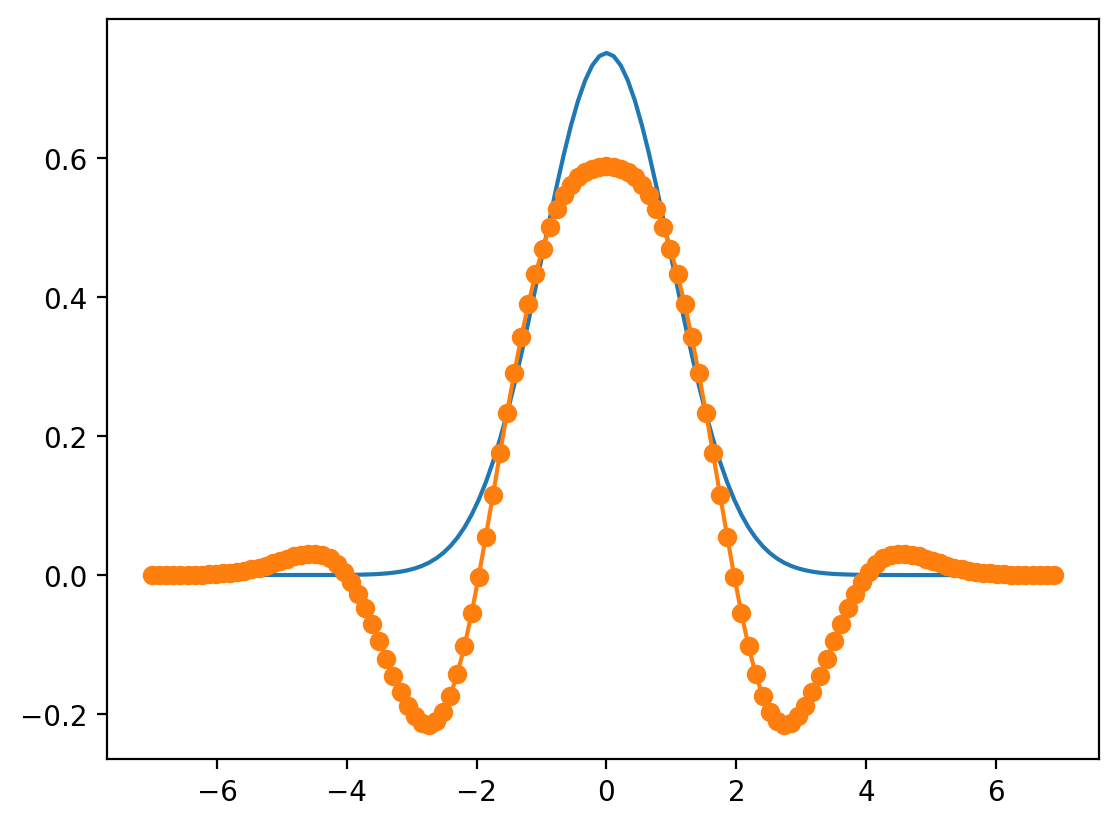

In [ ]:
# Quantum circuit for propagation
def qsolve():
  global psin,qc2
#   n=np.size(psin)
  d=int(np.log2(np.size(psin)))
  # Circuit
  qre = QuantumRegister(d)
  circ = QuantumCircuit(qre)
  circ.initialize(psin,qre)
  circ.barrier()
  circ.append(qc2, qre)
  circ.barrier()
  # Execution
  psin = execute(circ, backend=BasicAer.get_backend('statevector_simulator')).result()
  psin = psin.get_statevector()
  # Weighted sum of Fock states
  out=psin[0]*fock(occ,0)
  for j in range(1,occ):
    out+=psin[j]*fock(occ,j)
  return out

# Numerical inverse Wigner transform
def psirv3(n):
  for j in range(n):
    pstate=qsolve()
  wt=wigner(pstate,xvec/2,pv)
  out=np.zeros(np.size(xvec),dtype=complex)
  for k in range(np.size(xvec)):
    for j in range(np.size(pv)):
      out[k]+=dp*np.exp(1j*pv[j]*xvec[k])*wt[j,k]
  fo=np.sqrt(norm(out)**2*dx)
  return out/fo

ref=np.exp(-xvec**2/2)/(np.pi)**0.25
plot(xvec,np.real(ref),'-')
plot(xvec,np.real(psirv3(1830)),'-o')

In [ ]:
cb = None

def plot_result3(k,fig=None, axes=None):
    global cb
    xmin = -5
    xmax = 5
    axes.cla()

    W = wigner(qsolve(), xvec, xvec)
    surf = axes.plot_surface(X, Y, W, rstride=1, cstride=1, cmap=cm.jet,
                              alpha=0.75, linewidth=0.05, vmax=0.25, vmin=-0.25)
    axes.contour(X, Y, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
    axes.set_xlim3d(xmin, xmax)
    axes.set_ylim3d(xmin, xmax)
    axes.set_zlim3d(-0.25, 0.25)
    if not cb:
        cb = plt.colorbar(surf, shrink=0.65, aspect=20)
    return axes.artists

def update3(k):
    return plot_result3(k,fig=fig, axes=ax)

name = 'Surface-Animation-Qiskit'
# Set-up the figure
fig = plt.figure(figsize=(8, 4), dpi=100)
# Create 3D axes, add to figure
ax = Axes3D(fig, azim=-107, elev=29)
fig.add_axes(ax, projection='3D')
# Create animation object and run routine to save to a .mp4 file
anim = animation.FuncAnimation(fig, update3, frames=200, blit=True)
anim.save(name + '.mp4', fps=10, writer="ffmpeg", codec=None)
plt.close(fig)

# Open Video and display in notebook by converting to HTML with base64
video = open(name + '.mp4', "rb").read()
video_encoded = b64encode(video).decode("ascii")
video_tag = '<video controls src="data:video/x-m4v;base64,{0}" height=720px>'.format(video_encoded) # Set the height to rescale the output.
HTML(video_tag)